# PHYS 441/DATA SCI 421 FINAL

## Your Project Title

---

By YOUR NAME  
06 December 2023

### Instructions

This template for the final project is written as a Jupyter Notebook, which allows for a nice mix of standard text as well as software and plotting. 

Text in a Jupyter notebook is written using Markdown. The formatting is fairly straightforward, with many tutorials online ([this one is fairly comprehensive](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd)). 

Follow this template when completing the final project.

## Introduction

*Write one to two paragraphs providing context for the project. What measurement/analysis is going to be attempted and why is this important in the field in question.*

## Data

*Introduce the data by describing the measurements, how they were collected, and how you managed to curate them for this project. In many cases it will also be appropriate to show a figure of the data. Label axes and provide units where appropriate, figures require a caption (which can be written in a markdown cell immediately following any plots.*

          Galaxy  sigma  sigma_unc          M_BH     M_BH_unc-     M_BH_unc+
0  Circinus^c,^d  158.0       18.0  1.700000e+06  1.400000e+06  2.100000e+06
1       IC1459^e  340.0       17.0  2.800000e+09  1.600000e+09  3.900000e+09
2        MW^f,^g  105.0       20.0  4.100000e+06  3.500000e+06  4.700000e+06
3      N0221 M32   75.0        3.0  3.100000e+06  2.500000e+06  3.700000e+06
4      N0224 M31  160.0        8.0  1.500000e+08  1.200000e+08  2.400000e+08


Text(0.5, 1.0, 'M-$\\sigma$ relationship ($\\sigma$ IS log scale)')

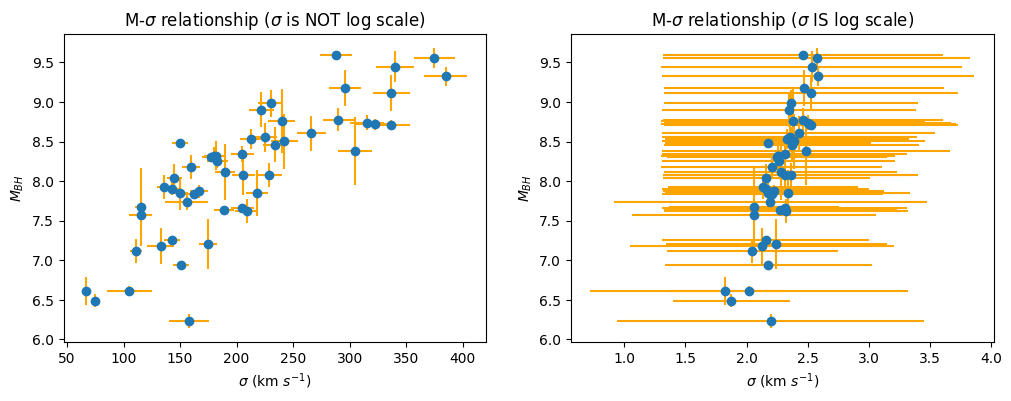

In [388]:
import scipy 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

# read file 
df = pd.read_csv('M-sigma.csv') 

print(df.head()) 

# uncertainty of black hole mass is symmetrical in log space 
M_BH_unc_high = np.array(df['M_BH_unc+'].to_list())
M_BH_unc_low  = np.array(df['M_BH_unc-'].to_list())
M_BH_unc = 0.5*(np.log10(M_BH_unc_high) - np.log10(M_BH_unc_low))
M_BH = np.log10(np.array(df['M_BH'].to_list())) 

# velocity and uncertainty of velocity 
sigma       = np.array(df['sigma'].to_list())
sigma_unc   = np.array(df['sigma_unc'].to_list())
# TODO: to calculate the log of the velocity, is it log(sigma - sigma_unc) or log(sigma) - log(sigma_unc)? 
sigma_log       = np.log10(np.array(df['sigma'].to_list()))  
sigma_unc_log   = np.log10(np.array(df['sigma_unc'].to_list())) 

fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
ax[0].errorbar(x=sigma, xerr=sigma_unc, y=M_BH, yerr=M_BH_unc, fmt="o", ecolor='orange')
ax[0].set_xlabel('$\sigma$ (km $s^{-1}$)') 
ax[0].set_ylabel('$M_{BH}$')
ax[0].set_title('M-$\sigma$ relationship ($\sigma$ is NOT log scale)')

ax[1].errorbar(x=sigma_log, xerr=sigma_unc_log, y=M_BH, yerr=M_BH_unc, fmt="o", ecolor='orange')
ax[1].set_xlabel('$\sigma$ (km $s^{-1}$)') 
ax[1].set_ylabel('$M_{BH}$')
ax[1].set_title('M-$\sigma$ relationship ($\sigma$ IS log scale)')


## Analysis/Results

*This is the bulk of the project - use statistical methods to analyze the data. This will require text to explain what you are doing (e.g., if you define a likelihood for the data, then you should write about how you arrived at that likelihood and write it out). The text should appear in markdown cells. This section will also present the software that executes the analysis, as well as any corresponding plots. Figures should have a caption (in a markdown cell). You will need multiple cells to complete this section. Units and uncertainties are important to report throughout this section (we never discussed significant figures in class, but please adhere to this in your reporting).* 

### Analysis 1: assuming sigma doesn't have uncertainties

The relationship between $M_{BH}$ and $\sigma$ is $M_{BH} = \alpha log(\sigma) + \beta$

#### Frequentist: Least squares using scipy.minimize

Text(0.5, 1.0, 'Best fit for a first degree estimate')

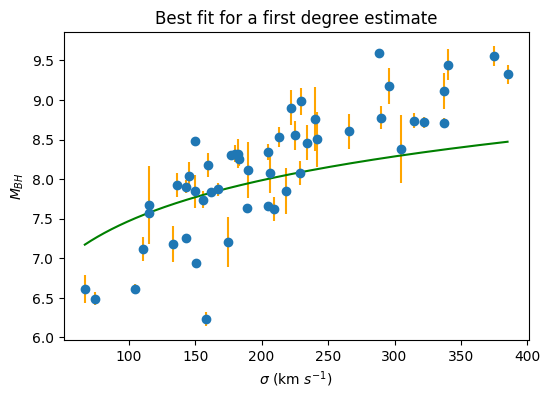

In [389]:

from scipy.optimize import minimize 

def model(theta, x):
    alpha, beta = theta
    return alpha*np.log10(x) + beta 

def nll(theta, y_obs, y_obs_unc, x_obs):
    return 0.5 * np.sum((y_obs-model(theta, x_obs))**2 / y_obs_unc**2)

init_guess = (0, 1)


alpha, beta = minimize(nll, init_guess, args=(M_BH, M_BH_unc, sigma)).x


x_axis = np.linspace(min(sigma), max(sigma), 1000)   
y_axis = alpha*np.log10(x_axis) + beta

fig, ax = plt.subplots(figsize=(6, 4), sharey=True)
ax.errorbar(sigma, M_BH, yerr=M_BH_unc, fmt="o", ecolor='orange')
ax.plot(x_axis, y_axis, color='green') 
ax.set_xlabel('$\sigma$ (km $s^{-1}$)') 
ax.set_ylabel('$M_{BH}$')
ax.set_title('Best fit for a first degree estimate')

#### Bayesian approach

The likelihood is given by

$$p(\{y_i\}|\{x_i\}, \{\sigma_{y_i}\}, m, b, A) = \frac{1}{\sqrt{2\pi A^2 \sigma_{y_i}^2}} \exp\left(-\frac{(y_i - mx_i - b)^2}{2A^2\sigma_{y_i}^2}\right)$$ 



/var/folders/mz/znfhl70963d19m5pmpb4zftr0000gn/T/ipykernel_20026/1626089712.py:24: RuntimeWarning: invalid value encountered in scalar divide
  h_ratio = np.exp(lnpost1)/np.exp(lnpost0) # complete
/var/folders/mz/znfhl70963d19m5pmpb4zftr0000gn/T/ipykernel_20026/1626089712.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  h_ratio = np.exp(lnpost1)/np.exp(lnpost0) # complete


[1.43409181 4.61833768 9.99830258]


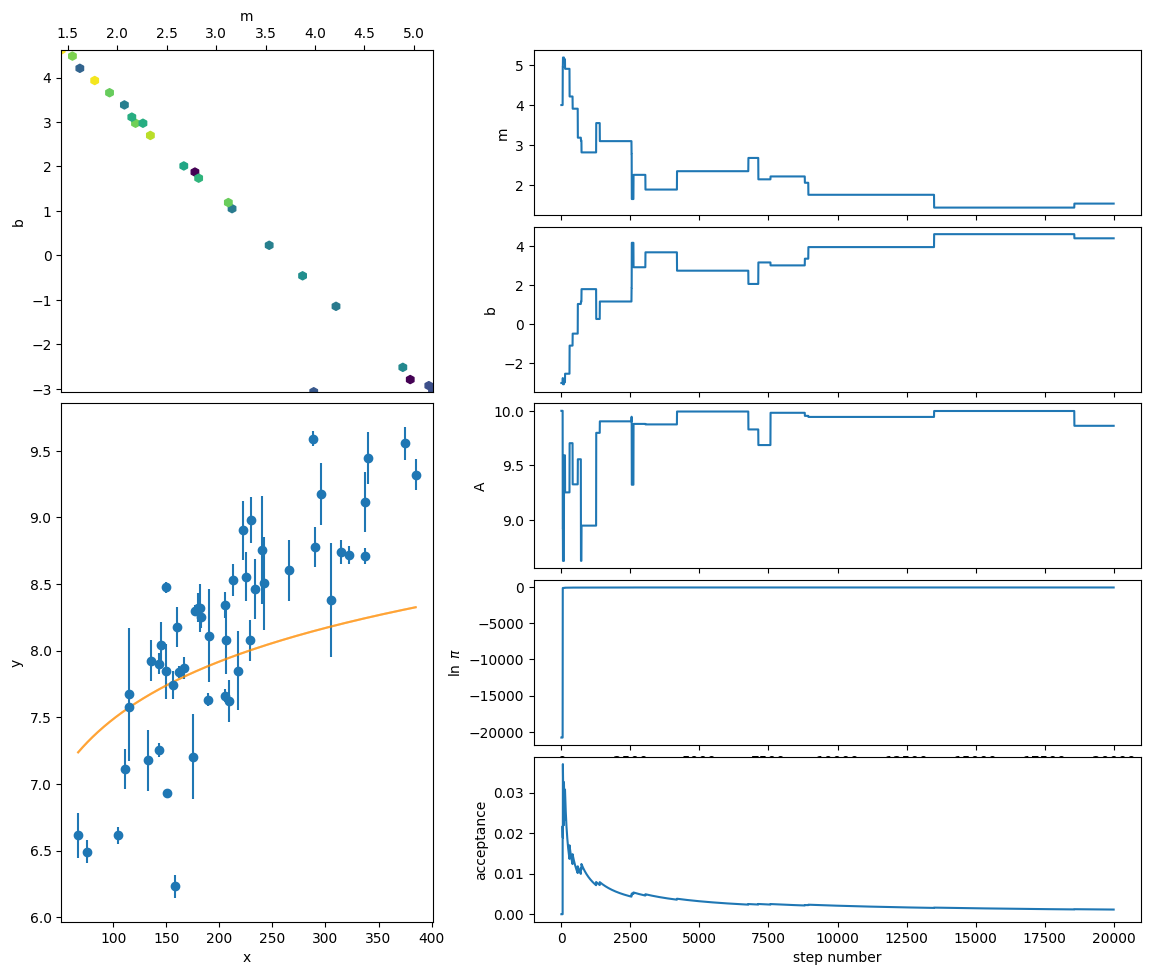

In [394]:
def lnlikelihood(theta, y, x, y_unc):
    m, b, A = theta # unpack model parameters from theta 
    model_preds = m*np.log10(x) + b # compute model predictions for each x value  
    lnl = -1 * np.sum( (y - model_preds)**2/(2*(A**2)*(y_unc**2)) ) # compute the log likelihood  
    return lnl 

def lnprior(theta):
  alpha, beta, A = theta
  if -10.0 < alpha < 10.0 and -10.0 < beta < 10.0 and (0 <= A <= 10): 
      return np.log(1/20) + np.log(1/20) + np.log(1/10)
  return -np.inf

def lnposterior(theta, y, x, y_unc): 
    lnp = lnprior(theta) # compute the log prior  
    if not np.isfinite(lnp): return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc) # the log likelihood function 
    
    return lnl + lnp # return the log posterior 

def hastings_ratio(theta_1, theta_0, y, x, y_unc):
    lnpost1 = lnposterior(theta_1, y, x, y_unc) # complete
    lnpost0 = lnposterior(theta_0, y, x, y_unc) # complete
    
    h_ratio = np.exp(lnpost1)/np.exp(lnpost0) # complete
    
    return h_ratio

def propose_jump(theta, cov):
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov) # complete
    
    return proposed_position

def mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc):
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0

    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y_obs, x, y_unc)

    for step_num in range(1,nsteps+1):
        new_pos = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(new_pos, positions[step_num-1], y_obs, x, y_unc)
        if H >= 1:
            positions[step_num] = new_pos
            lnpost_at_pos[step_num] = lnposterior(new_pos, y_obs, x, y_unc)
            accepted += 1
            acceptance_ratio[step_num] = accepted/step_num
        else:
            r = np.random.rand()
            if r <= H: 
                positions[step_num] = new_pos
                lnpost_at_pos[step_num] = lnposterior(new_pos, y_obs, x, y_unc)
                accepted += 1
                acceptance_ratio[step_num] = accepted/step_num
            else:
                positions[step_num] = positions[step_num-1]
                lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
                acceptance_ratio[step_num] = accepted/step_num
    
    return (positions, lnpost_at_pos, acceptance_ratio)

def plot_mh_summary(theta_0, cov, nsteps, y_obs, x, y_unc):
    pos, lnpost, acc = mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc)

    fig = plt.figure(figsize=(12,10))
    ax1 = plt.subplot2grid((5,5), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((5,5), (2, 0), colspan=2, rowspan=3)
    ax3 = plt.subplot2grid((5,5), (0, 2), colspan=3)
    ax4 = plt.subplot2grid((5,5), (1, 2), colspan=3, sharex=ax3)
    ax5 = plt.subplot2grid((5,5), (2, 2), colspan=3, sharex=ax3)
    ax6 = plt.subplot2grid((5,5), (3, 2), colspan=3, sharex=ax3)
    ax7 = plt.subplot2grid((5,5), (4, 2), colspan=3, sharex=ax3)

    top_10 = sorted(zip(pos, lnpost), key=lambda x: x[1], reverse=True)[:3]
    top_pos, _ = top_10[0]
    print(top_pos)

    # posterior
    ax1.hexbin(pos[:,0], pos[:,1], gridsize=50, mincnt=1, bins='log')
    all_m, all_b = pos[:,0], pos[:,1]
    ylims = (min(all_b), max(all_b)) 
    xlims = (min(all_m), max(all_m)) 
    ax1.plot([top_pos[0], top_pos[0]], ylims, 'Crimson', alpha=0.3)
    ax1.plot(xlims, [top_pos[1], top_pos[1]], 'Crimson', alpha=0.3)
    ax1.set_ylim(ylims)
    ax1.set_xlim(xlims)
    ax1.set_xlabel('m')
    ax1.set_ylabel('b')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.tick_params(top=True, bottom=False)

    ax2.errorbar(x, y_obs, y_unc, fmt='o')
    # for draw in np.random.choice(len(pos), 10, replace=False):
    #     ax2.plot([0,max(x)], pos[draw,1] + pos[draw,0]*np.array([0, max(x)]),
    #              'DarkOrange', alpha=0.4)
    for (_pos, _) in top_10: 
        x_axis = np.linspace(min(x), max(x), 1000) 
        y_axis = _pos[0]*np.log10(x_axis) + _pos[1] 
        ax2.plot(x_axis, y_axis, 'DarkOrange', alpha=0.4)





        # ax2.plot([0,max(x)], np.log10((_pos[0]*np.linspace(0.1, max(x), 1000))  +_pos[1], 'DarkOrange', alpha=0.4)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.plot(pos[:,0])
    ax3.set_ylabel('m')
    
    ax4.plot(pos[:,1])
    ax4.set_ylabel('b')

    ax5.plot(pos[:,2])
    ax5.set_ylabel('A')

    ax6.plot(lnpost)
    ax6.set_ylabel('$\ln \; \pi$')

    ax7.plot(acc)
    ax7.set_ylabel('acceptance')
    ax7.set_xlabel('step number')
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax5.get_xticklabels(), visible=False)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, left=0.09, right=0.99, hspace=0.07, wspace=0.75)

    return pos, lnpost, acc 

starting_m_b = (4, -3, 10) 
cov = (1, 1, 1) 

# pos, lnpost, acc = mh_mcmc(starting_m_b, cov, 2000, y, x, y_unc)
pos, lnpost, acc = plot_mh_summary(starting_m_b, cov, 20000, M_BH, sigma, M_BH_unc) 

#### Using EMCEE

/Users/hyes92121/miniconda3/envs/ds421/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


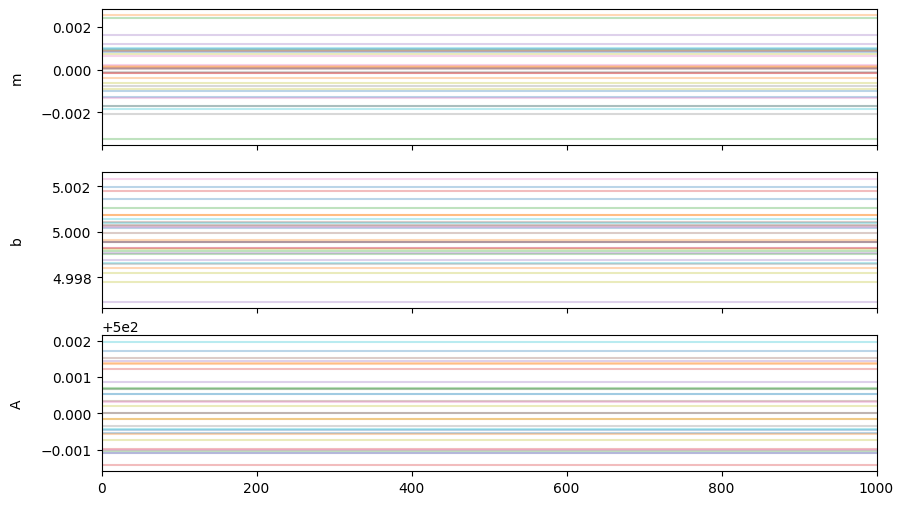

In [391]:
import emcee 
import corner 

initial = (0, 5, 500)  
ndim = len(initial)
nwalkers = 32
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(sigma, M_BH, M_BH_unc))
sampler.run_mcmc(p0, 1000, progress=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)


samples = sampler.get_chain()
labels = ['m', 'b', 'A']

for i in range(3):
    ax[i].plot(samples[:, :, i], alpha=0.3)
    ax[i].set_xlim(0, len(samples))
    ax[i].set_ylabel(labels[i])
    ax[i].yaxis.set_label_coords(-0.1, 0.5)


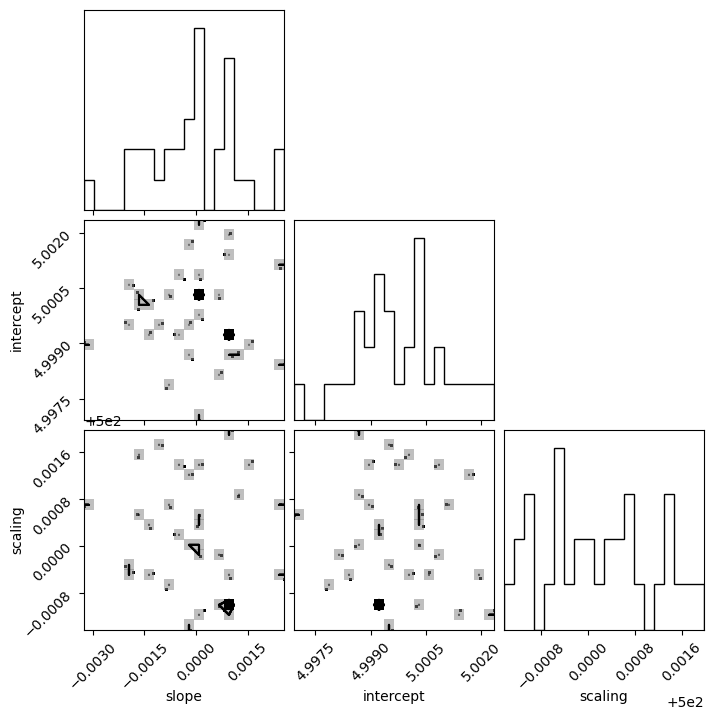

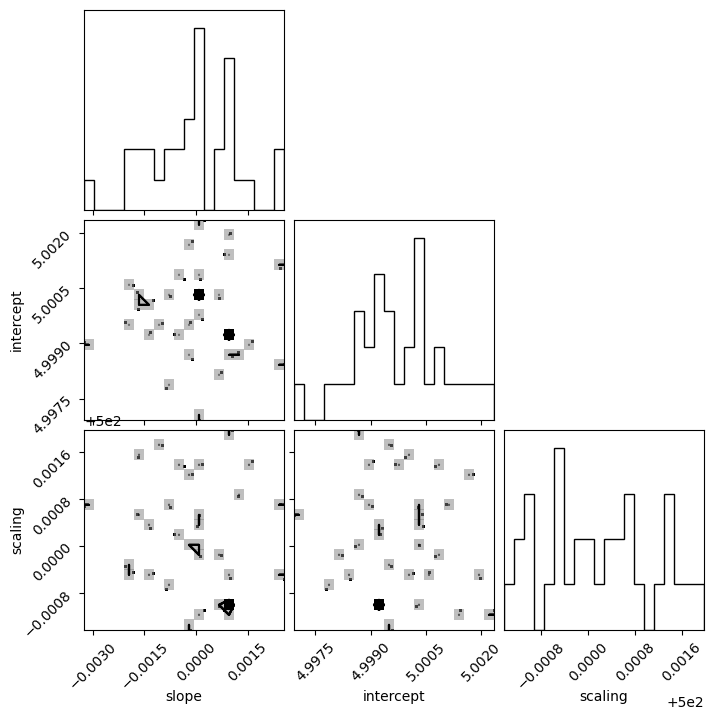

In [392]:
labels = ["slope", "intercept", 'scaling']
corner.corner(sampler.flatchain, labels=labels)

## Conclusions

*Write a few sentences summarizing the big take away from your analysis (e.g., I attempted to fit observations to measure the mass of an electron and I found $m_e = MMM.MMM \pm 0.MMM\,\mathrm{MeV}$...)*